In [1]:
import random
import json
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from avaml.aggregatedata import ForecastDataset, LabeledData, REG_ENG, CsvMissingError
from utils.plot_distributions import *

# Introduction

The goal of this Jupyter Notebook is to get a better idea of how our input and output features are formatted. Additionally, I will be looking at how different variables vary, both temporally and spatially. I believe this is important because in order to train a machine learning model, we will need to split the data somehow. 

However, my intuition is that there will be a lot of inter-seasonal variability, making a data split on years or seasons (over all regions) a bad choice. In some ways, you could look at splitting the data over years or seasons as a best-worst case scenario. That is, if there is a lot of variability through time, predicting for a new season could be as good or bad as the model is able to predict output features. And due to climate change, we may very well get data that looks quite different from historical records, making the model ill-suited to predict new data.

My hypothesis is that splitting the data by regions is a better choice. There are 23 regions in total, so you could imagine splitting the input data into 3 groups for a training, validation, and test set. The key to this approach is to realize that regions next to each other will most likely be spatially autocorrelated. 

To overcome this bias, we will need to think about how to choose regions, say for the training set, that minimize this spatial autocorrelation. Additionally, and this is **very important**, we will also need to group the regions so that the training, validation, and testing sets have the same or very close to the same distribution of values. Otherwise, we will be training the model on one set of data, but our model will be unable to correctly predict for our "target" or test set.

# Read in data

In [2]:
model_prefix = ''
days = 1
regobs_types = list(REG_ENG.keys())
labeled_data = None
try:
    print("Reading csv")
    labeled_data = LabeledData.from_csv(days=days, regobs_types=regobs_types, with_varsom=True)
except CsvMissingError:
    print("Csv missing. Fetching online data. (This takes a long time.)")
    labeled_data = ForecastDataset(regobs_types=regobs_types).label(days=days, with_varsom=True)
    labeled_data.to_csv()

Reading csv


In [3]:
labeled_data

In [4]:
vars(labeled_data).keys()

dict_keys(['data', 'row_weight', 'label', 'pred', 'days', 'with_varsom', 'regobs_types', 'single', 'seasons', 'with_regions'])

In [5]:
labeled_data.data.shape

(13115, 291)

In [6]:
labeled_data.data.head()

region_id_3001 region_id_3002 region_id_3003 region_id_3004  \
                             0              0              0              0   
2017-11-23 3031            0.0            0.0            0.0            0.0   
           3034            0.0            0.0            0.0            0.0   
2017-12-02 3003            0.0            0.0            1.0            0.0   
           3007            0.0            0.0            0.0            0.0   
           3009            0.0            0.0            0.0            0.0   

                region_id_3005 region_id_3006 region_id_3007 region_id_3008  \
                             0              0              0              0   
2017-11-23 3031            0.0            0.0            0.0            0.0   
           3034            0.0            0.0            0.0            0.0   
2017-12-02 3003            0.0            0.0            0.0            0.0   
           3007            0.0            0.0            1.0            0.0   
           3009            0.0            0.0            0.0            0.0   

                region_id_3009 region_id_3010  ... wind_chg_dir_W  \
                             0              0  ...              0   
2017-11-23 3031            0.0            0.0  ...            0.0   
           3034            0.0            0.0  ...            0.0   
2017-12-02 3003            0.0            0.0  ...            0.0   
           3007            0.0            0.0  ...            0.0   
           3009            1.0            0.0  ...            0.0   

                wind_chg_dir_NW wind_chg_start_0 wind_chg_start_6  \
                              0                0                0   
2017-11-23 3031             0.0              0.0              0.0   
           3034             0.0              0.0              0.0   
2017-12-02 3003             0.0              0.0              0.0   
           3007             0.0              0.0              0.0   
           3009             0.0              0.0              0.0   

                wind_chg_start_12 wind_chg_start_18 temp_fl_start_0  \
                                0                 0               0   
2017-11-23 3031               0.0               0.0             0.0   
           3034               0.0               0.0             0.0   
2017-12-02 3003               0.0               0.0             0.0   
           3007               0.0               1.0             0.0   
           3009               0.0               1.0             0.0   

                temp_fl_start_6 temp_fl_start_12 temp_fl_start_18  
                              0                0                0  
2017-11-23 3031             1.0              0.0              0.0  
           3034             1.0              0.0              0.0  
2017-12-02 3003             0.0              0.0              0.0  
           3007             1.0              0.0              0.0  
           3009             1.0              0.0              0.0  

[5 rows x 291 columns]

# Data formatting

In [7]:
# first, drop regions
labeled_data.data = labeled_data.drop_regions().data

# then, rename indices
labeled_data.data = labeled_data.data.rename_axis(['date','region'])
labeled_data.label = labeled_data.label.rename_axis(['date', 'region'])

# flatten the hierchy of columns to 1D
labeled_data.data.columns = [' '.join(col).strip().replace(' ', '_') for col in labeled_data.data.columns.values]
labeled_data.label.columns = [' '.join(col).strip().replace(' ', '_') for col in labeled_data.label.columns.values]

# replace double underscores with single underscores
labeled_data.data.columns = [col.replace('__', '_') for col in labeled_data.data.columns.values]
labeled_data.label.columns = [col.replace('__', '_') for col in labeled_data.label.columns.values]

# replace dashes with single underscores
labeled_data.data.columns = [col.replace('-', '_') for col in labeled_data.data.columns.values]
labeled_data.label.columns = [col.replace('-', '_') for col in labeled_data.label.columns.values]

# convert some columns in labels to type int for averaging
labeled_data.label['CLASS_problem_amount'] = labeled_data.label['CLASS_problem_amount'].astype(int)
labeled_data.label['CLASS_danger_level'] = labeled_data.label['CLASS_danger_level'].astype(int)

for column in labeled_data.label.columns:
    if column.endswith(('_dist', '_dsize', '_lev_fill', '_prob', '_trig')):
        labeled_data.label[column] = labeled_data.label[column].astype(int)
        
# below, we can try to make categorical variables in the labels numeric
# first for the emergency warning column
warning_dict = {'Ikke gitt':0,
                'Naturlig utløste skred':1}

labeled_data.label['CLASS_emergency_warning'] = labeled_data.label['CLASS_emergency_warning'].replace(warning_dict)

# and now for the class problems
problem1 = list(np.unique(labeled_data.label.loc[:, 'CLASS_problem_1'].values))
problem2 = list(np.unique(labeled_data.label.loc[:, 'CLASS_problem_2'].values))
problem3 = list(np.unique(labeled_data.label.loc[:, 'CLASS_problem_3'].values))

list_of_problems = sorted(list(np.unique(problem1 + problem2 + problem3)))
problems_dict = {'':0, 'drift-slab':1, 'glide':2, 'new-loose':3,
                 'new-slab':4, 'pwl-slab':5, 'wet-loose':6, 'wet-slab':7}

labeled_data.label['CLASS_problem_1'] = labeled_data.label['CLASS_problem_1'].replace(problems_dict)
labeled_data.label['CLASS_problem_2'] = labeled_data.label['CLASS_problem_2'].replace(problems_dict)
labeled_data.label['CLASS_problem_3'] = labeled_data.label['CLASS_problem_3'].replace(problems_dict)

In [8]:
labeled_data.data.head()

danger_level_1  emergency_warning_1  problem_amount_1  \
date       region                                                          
2017-11-23 3031               4.0                  1.0               1.0   
           3034               4.0                  1.0               1.0   
2017-12-02 3003               1.0                  1.0               1.0   
           3007               2.0                  1.0               2.0   
           3009               2.0                  1.0               2.0   

                   problem_new_loose_1  problem_wet_loose_1  \
date       region                                             
2017-11-23 3031                    0.0                  0.0   
           3034                    0.0                  0.0   
2017-12-02 3003                    0.0                  0.0   
           3007                    0.0                  0.0   
           3009                    0.0                  0.0   

                   problem_new_slab_1  problem_drift_slab_1  \
date       region                                             
2017-11-23 3031                   0.0                   3.0   
           3034                   0.0                   3.0   
2017-12-02 3003                   0.0                   3.0   
           3007                   0.0                   3.0   
           3009                   0.0                   3.0   

                   problem_pwl_slab_1  problem_wet_slab_1  problem_glide_1  \
date       region                                                            
2017-11-23 3031                   0.0                 0.0              0.0   
           3034                   0.0                 0.0              0.0   
2017-12-02 3003                   0.0                 0.0              0.0   
           3007                   2.0                 0.0              0.0   
           3009                   2.0                 0.0              0.0   

                   ...  wind_chg_dir_W_0  wind_chg_dir_NW_0  \
date       region  ...                                        
2017-11-23 3031    ...               0.0                0.0   
           3034    ...               0.0                0.0   
2017-12-02 3003    ...               0.0                0.0   
           3007    ...               0.0                0.0   
           3009    ...               0.0                0.0   

                   wind_chg_start_0_0  wind_chg_start_6_0  \
date       region                                           
2017-11-23 3031                   0.0                 0.0   
           3034                   0.0                 0.0   
2017-12-02 3003                   0.0                 0.0   
           3007                   0.0                 0.0   
           3009                   0.0                 0.0   

                   wind_chg_start_12_0  wind_chg_start_18_0  \
date       region                                             
2017-11-23 3031                    0.0                  0.0   
           3034                    0.0                  0.0   
2017-12-02 3003                    0.0                  0.0   
           3007                    0.0                  1.0   
           3009                    0.0                  1.0   

                   temp_fl_start_0_0  temp_fl_start_6_0  temp_fl_start_12_0  \
date       region                                                             
2017-11-23 3031                  0.0                1.0                 0.0   
           3034                  0.0                1.0                 0.0   
2017-12-02 3003                  0.0                0.0                 0.0   
           3007                  0.0                1.0                 0.0   
           3009                  0.0                1.0                 0.0   

                   temp_fl_start_18_0  
date       region                      
2017-11-23 3031                   0.0  
           3034                   0.0  
2017-12-02 3003              

In [9]:
labeled_data.label.head()

CLASS_danger_level  CLASS_emergency_warning  \
date       region                                                
2017-11-23 3031                     4                        0   
           3034                     4                        0   
2017-12-02 3003                     1                        0   
           3007                     2                        0   
           3009                     2                        0   

                   CLASS_problem_1  CLASS_problem_2  CLASS_problem_3  \
date       region                                                      
2017-11-23 3031                  1                0                0   
           3034                  1                0                0   
2017-12-02 3003                  1                0                0   
           3007                  5                0                0   
           3009                  5                0                0   

                   CLASS_problem_amount CLASS_drift_slab_cause  \
date       region                                                
2017-11-23 3031                       1              snowdrift   
           3034                       1              snowdrift   
2017-12-02 3003                       1              snowdrift   
           3007                       1                      0   
           3009                       1                      0   

                   CLASS_drift_slab_dist  CLASS_drift_slab_dsize  \
date       region                                                  
2017-11-23 3031                        3                       3   
           3034                        3                       3   
2017-12-02 3003                        1                       2   
           3007                        0                       0   
           3009                        0                       0   

                   CLASS_drift_slab_lev_fill  ...  REAL_new_loose_lev_max  \
date       region                             ...                           
2017-11-23 3031                            1  ...                     0.0   
           3034                            1  ...                     0.0   
2017-12-02 3003                            1  ...                     0.0   
           3007                            0  ...                     0.0   
           3009                            0  ...                     0.0   

                   REAL_new_loose_lev_min REAL_new_slab_lev_max  \
date       region                                                 
2017-11-23 3031                       0.0                   0.0   
           3034                       0.0                   0.0   
2017-12-02 3003                       0.0                   0.0   
           3007                       0.0                   0.0   
           3009                       0.0                   0.0   

                   REAL_new_slab_lev_min  REAL_pwl_slab_lev_max  \
date       region                                                 
2017-11-23 3031                      0.0                    0.0   
           3034                      0.0                    0.0   
2017-12-02 3003                      0.0                    0.0   
           3007                      0.0                  400.0   
           3009                      0.0                  400.0   

                   REAL_pwl_slab_lev_min  REAL_wet_loose_lev_max  \
date       region                                                  
2017-11-23 3031                      0.0                     0.0   
           3034                      0.0                     0.0   
2017-12-02 3003                      0.0                     0.0   
           3007                      0.0                     0.0   
           3009                      0.0                     0.0   

                   REAL_wet_loose_lev_min REAL_wet_slab_lev_max  \
date       region                                                 
2017-11-23 3031     

# Clustering data by region and time

I can look at how key variables are distributed for every region and all times. Then we can compare this to how how variables are distributed when clustering them by region or season. I am interested in understanding how certain input variables are correlated to the output variables of interest. This includes how different snow pack conditions vary with avlanche problems and danger level warnings, but also how these input and output variables change with time, across different regions, etc.

The data is formatted as a MultiIndex in Pandas. This means we can first subset by time, then by region ID.

## By time

In [10]:
# first, the overall means
label_means_all = pd.DataFrame(labeled_data.label.mean()[labeled_data.label.mean() != np.infty])
label_means_all.columns = ['all_seasons']
#label_means_all

In [11]:
# look at df from one day, there should be 21 regions
labeled_data.data.loc['2017-12-07'].shape

(21, 245)

In [12]:
labeled_data.data.loc['2017-12-07']

,danger_level_1,emergency_warning_1,problem_amount_1,problem_new_loose_1,problem_wet_loose_1,problem_new_slab_1,problem_drift_slab_1,problem_pwl_slab_1,problem_wet_slab_1,problem_glide_1,...,wind_chg_dir_W_0,wind_chg_dir_NW_0,wind_chg_start_0_0,wind_chg_start_6_0,wind_chg_start_12_0,wind_chg_start_18_0,temp_fl_start_0_0,temp_fl_start_6_0,temp_fl_start_12_0,temp_fl_start_18_0
region,,,,,,,,,,,,,,,,,,,,,
3003,1.0,1.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3007,3.0,1.0,2.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3009,3.0,1.0,2.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3010,3.0,1.0,2.0,0.0,0.0,0.0,2.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3011,3.0,1.0,2.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3012,3.0,1.0,2.0,0.0,0.0,0.0,2.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3013,3.0,1.0,2.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3014,2.0,1.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3015,3.0,1.0,2.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [13]:
labeled_data.data.loc['2017-12-07'].mean().head(6)

danger_level_1         2.666667
emergency_warning_1    0.809524
problem_amount_1       1.952381
problem_new_loose_1    0.095238
problem_wet_loose_1    0.428571
problem_new_slab_1     0.952381
dtype: float64

In [14]:
dates_list = list(labeled_data.data.index.get_level_values(0))

#find start and end dates for each season
season_start_1 = 0
season_end_1 = np.where(np.array(dates_list) == '2018-05-31')[0][-1]

season_start_2 = season_end_1 + 1
season_end_2 = np.where(np.array(dates_list) == '2019-05-31')[0][-1]

season_start_3 = season_end_2 + 1
season_end_3 = np.where(np.array(dates_list) == '2020-06-14')[0][-1]

season_start_4 = season_end_3 + 1

print('Season 1 dates: from {} until {}'.format(dates_list[season_start_1], dates_list[season_end_1]))
print('Season 2 dates: from {} until {}'.format(dates_list[season_start_2], dates_list[season_end_2]))
print('Season 3 dates: from {} until {}'.format(dates_list[season_start_3], dates_list[season_end_3]))
print('Season 4 dates: from {} until {}'.format(dates_list[season_start_4], dates_list[-1]))

Season 1 dates: from 2017-11-23 until 2018-05-31
Season 2 dates: from 2018-12-01 until 2019-05-31
Season 3 dates: from 2019-12-02 until 2020-06-14
Season 4 dates: from 2020-12-02 until 2021-01-12


In [15]:
first_data = labeled_data.data.iloc[:season_end_1+1]
second_data = labeled_data.data.iloc[season_start_2:season_end_2+1]
third_data = labeled_data.data.iloc[season_start_3:season_end_3+1]
fourth_data = labeled_data.data.iloc[season_start_4:]

first_labels = labeled_data.label.iloc[:season_end_1]
second_labels = labeled_data.label.iloc[season_start_2:season_end_2]
third_labels = labeled_data.label.iloc[season_start_3:season_end_3]
fourth_labels = labeled_data.label.iloc[season_start_4:]

print('Dataframe for 2017-2018 season has {} data points.'.format(len(first_data)))
print('Dataframe for 2018-2019 season has {} data points.'.format(len(second_data)))
print('Dataframe for 2019-2020 season has {} data points.'.format(len(third_data)))
print('Dataframe for 2020-2021 season has {} data points.'.format(len(fourth_data)))

Dataframe for 2017-2018 season has 3814 data points.
Dataframe for 2018-2019 season has 3906 data points.
Dataframe for 2019-2020 season has 4429 data points.
Dataframe for 2020-2021 season has 966 data points.


In [16]:
length_all_seasons = len(first_data) + len(second_data) + len(third_data) + len(fourth_data)
assert(length_all_seasons == len(labeled_data.data))

In [17]:
first_labels.head()

CLASS_danger_level  CLASS_emergency_warning  \
date       region                                                
2017-11-23 3031                     4                        0   
           3034                     4                        0   
2017-12-02 3003                     1                        0   
           3007                     2                        0   
           3009                     2                        0   

                   CLASS_problem_1  CLASS_problem_2  CLASS_problem_3  \
date       region                                                      
2017-11-23 3031                  1                0                0   
           3034                  1                0                0   
2017-12-02 3003                  1                0                0   
           3007                  5                0                0   
           3009                  5                0                0   

                   CLASS_problem_amount CLASS_drift_slab_cause  \
date       region                                                
2017-11-23 3031                       1              snowdrift   
           3034                       1              snowdrift   
2017-12-02 3003                       1              snowdrift   
           3007                       1                      0   
           3009                       1                      0   

                   CLASS_drift_slab_dist  CLASS_drift_slab_dsize  \
date       region                                                  
2017-11-23 3031                        3                       3   
           3034                        3                       3   
2017-12-02 3003                        1                       2   
           3007                        0                       0   
           3009                        0                       0   

                   CLASS_drift_slab_lev_fill  ...  REAL_new_loose_lev_max  \
date       region                             ...                           
2017-11-23 3031                            1  ...                     0.0   
           3034                            1  ...                     0.0   
2017-12-02 3003                            1  ...                     0.0   
           3007                            0  ...                     0.0   
           3009                            0  ...                     0.0   

                   REAL_new_loose_lev_min REAL_new_slab_lev_max  \
date       region                                                 
2017-11-23 3031                       0.0                   0.0   
           3034                       0.0                   0.0   
2017-12-02 3003                       0.0                   0.0   
           3007                       0.0                   0.0   
           3009                       0.0                   0.0   

                   REAL_new_slab_lev_min  REAL_pwl_slab_lev_max  \
date       region                                                 
2017-11-23 3031                      0.0                    0.0   
           3034                      0.0                    0.0   
2017-12-02 3003                      0.0                    0.0   
           3007                      0.0                  400.0   
           3009                      0.0                  400.0   

                   REAL_pwl_slab_lev_min  REAL_wet_loose_lev_max  \
date       region                                                  
2017-11-23 3031                      0.0                     0.0   
           3034                      0.0                     0.0   
2017-12-02 3003                      0.0                     0.0   
           3007                      0.0                     0.0   
           3009                      0.0                     0.0   

                   REAL_wet_loose_lev_min REAL_wet_slab_lev_max  \
date       region                                                 
2017-11-23 3031     

In [18]:
first_labels.tail()

CLASS_danger_level  CLASS_emergency_warning  \
date       region                                                
2018-05-31 3028                     1                        0   
           3029                     1                        0   
           3031                     1                        0   
           3032                     1                        0   
           3034                     1                        0   

                   CLASS_problem_1  CLASS_problem_2  CLASS_problem_3  \
date       region                                                      
2018-05-31 3028                  6                0                0   
           3029                  6                0                0   
           3031                  6                0                0   
           3032                  6                0                0   
           3034                  6                0                0   

                   CLASS_problem_amount CLASS_drift_slab_cause  \
date       region                                                
2018-05-31 3028                       1                      0   
           3029                       1                      0   
           3031                       1                      0   
           3032                       1                      0   
           3034                       1                      0   

                   CLASS_drift_slab_dist  CLASS_drift_slab_dsize  \
date       region                                                  
2018-05-31 3028                        0                       0   
           3029                        0                       0   
           3031                        0                       0   
           3032                        0                       0   
           3034                        0                       0   

                   CLASS_drift_slab_lev_fill  ...  REAL_new_loose_lev_max  \
date       region                             ...                           
2018-05-31 3028                            0  ...                     0.0   
           3029                            0  ...                     0.0   
           3031                            0  ...                     0.0   
           3032                            0  ...                     0.0   
           3034                            0  ...                     0.0   

                   REAL_new_loose_lev_min REAL_new_slab_lev_max  \
date       region                                                 
2018-05-31 3028                       0.0                   0.0   
           3029                       0.0                   0.0   
           3031                       0.0                   0.0   
           3032                       0.0                   0.0   
           3034                       0.0                   0.0   

                   REAL_new_slab_lev_min  REAL_pwl_slab_lev_max  \
date       region                                                 
2018-05-31 3028                      0.0                    0.0   
           3029                      0.0                    0.0   
           3031                      0.0                    0.0   
           3032                      0.0                    0.0   
           3034                      0.0                    0.0   

                   REAL_pwl_slab_lev_min  REAL_wet_loose_lev_max  \
date       region                                                  
2018-05-31 3028                      0.0                  1400.0   
           3029                      0.0                  1200.0   
           3031                      0.0                  1200.0   
           3032                      0.0                  1500.0   
           3034                      0.0                  1200.0   

                   REAL_wet_loose_lev_min REAL_wet_slab_lev_max  \
date       region                                                 
2018-05-31 3028     

In [19]:
season_labels = [first_labels, second_labels, third_labels, fourth_labels]
season_label_means = [df.mean() for df in season_labels]

label_means_seasons = pd.concat(season_label_means, axis=1)
label_means_seasons.columns = ['2017-2018', '2018-2019', '2019-2020', '2020-2021']

drop_list = ['MULTI_wet_slab_aspect', 'MULTI_glide_aspect', 'MULTI_new_loose_aspect',
            'MULTI_new_slab_aspect', 'MULTI_pwl_slab_aspect', 'MULTI_wet_loose_aspect',
            'MULTI_wet_slab_aspect', 'MULTI_drift_slab_aspect', 'CLASS_glide_cause']

label_means_seasons = label_means_seasons.drop(index=drop_list)

reordered_idx = ['2017-2018', '2018-2019', '2019-2020', '2020-2021', 'all_seasons']
compare_means = pd.concat([label_means_all, label_means_seasons], axis=1).T.loc[reordered_idx, :]
compare_means

,CLASS_danger_level,CLASS_emergency_warning,CLASS_problem_1,CLASS_problem_2,CLASS_problem_3,CLASS_problem_amount,CLASS_drift_slab_dist,CLASS_drift_slab_dsize,CLASS_drift_slab_lev_fill,CLASS_drift_slab_prob,...,REAL_new_loose_lev_max,REAL_new_loose_lev_min,REAL_new_slab_lev_max,REAL_new_slab_lev_min,REAL_pwl_slab_lev_max,REAL_pwl_slab_lev_min,REAL_wet_loose_lev_max,REAL_wet_loose_lev_min,REAL_wet_slab_lev_max,REAL_wet_slab_lev_min
2017-2018,2.120378,0.103331,3.349069,2.478101,0.222659,1.653029,1.014162,1.153685,0.549961,1.651980,...,4.038815,0.524521,107.448204,2.386572,297.141359,43.063205,248.308419,46.236559,82.507212,15.892998
2018-2019,2.037132,0.102177,3.308067,2.073752,0.195903,1.513444,0.962612,1.107810,0.515493,1.567478,...,7.912932,1.792574,142.919334,7.631242,216.286812,26.248399,238.258643,51.241997,86.120359,22.688860
2019-2020,2.292457,0.111111,2.817751,2.511969,0.282294,1.655827,1.299232,1.540876,0.675474,2.064589,...,7.813911,7.429991,72.944896,72.944896,195.957543,178.771454,232.859079,226.490515,119.828365,106.820235
2020-2021,1.546584,0.006211,2.407867,0.506211,0.006211,1.144928,0.886128,1.044513,0.677019,2.053830,...,2.587992,2.587992,87.474120,87.474120,210.559006,203.416149,30.227743,29.296066,7.556936,6.625259
all_seasons,2.111170,0.098437,3.088601,2.223332,0.218833,1.574838,1.085398,1.262448,0.591308,1.795349,...,6.359131,3.385437,104.963782,34.037362,232.459016,95.676706,224.170797,107.403736,90.644300,47.929851


### Plotting seasonal and overall distributions
### Weather data
Thank you to these two resources in helping me plot multiple dataframes side by side below:
- https://stackoverflow.com/questions/38106730/plotting-multiple-histograms-in-matplotlib-colors-or-side-by-side-bars
- https://www.thetopsites.net/article/53698519.shtml

And this excellent resource for rotating axis labels for multiple subplots:
- https://www.pythoncharts.com/2019/05/17/rotating-axis-labels/

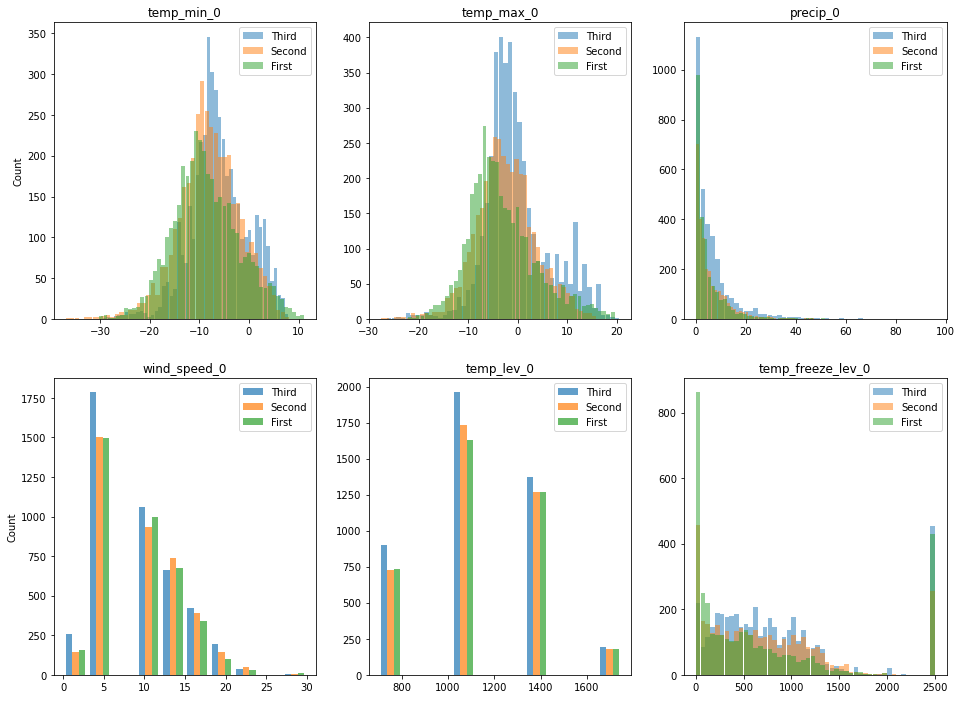

In [20]:
plot_season_weather(labeled_data.data, first_data, second_data, third_data)

### Danger level and dsize

In [21]:
# we are interested in the danger level and dsize columns
col_list = [column for column in compare_means.columns if 'lev' in column or 'dsize' in column]

# this should be a tuple, not a list
find_lev = ('lev_fill', 'lev_max', 'lev_min')
lev_fill_min_max = [column for column in col_list if column.endswith(find_lev)]

# but not the lev_fill, lev_min, or lev_max columns
# those need to be processed separately
[col for col in col_list if col not in lev_fill_min_max]

['CLASS_danger_level',
 'CLASS_drift_slab_dsize',
 'CLASS_glide_dsize',
 'CLASS_new_loose_dsize',
 'CLASS_new_slab_dsize',
 'CLASS_pwl_slab_dsize',
 'CLASS_wet_loose_dsize',
 'CLASS_wet_slab_dsize']

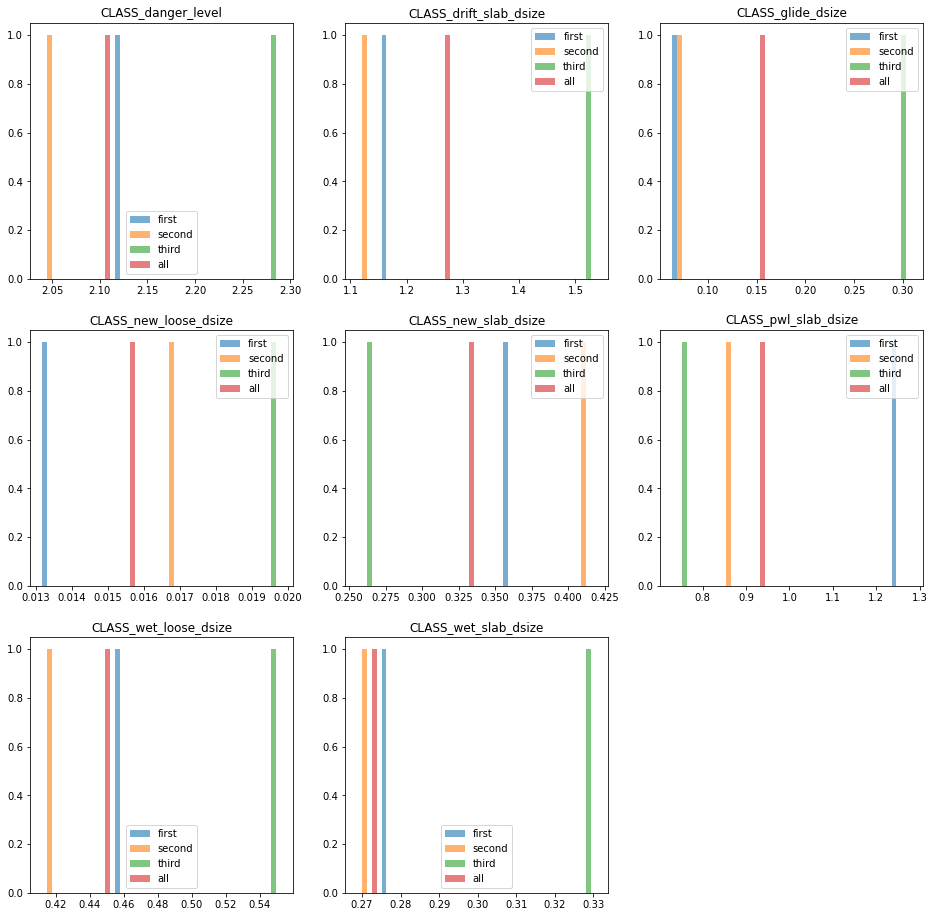

In [22]:
danger_dsize_list = [col for col in col_list if col not in lev_fill_min_max]
season_labels = [first_labels, second_labels, third_labels, fourth_labels]
plot_season_danger_dsize(season_labels, compare_means, danger_dsize_list, 
                         3, 3, (16, 16), 0, 12, 'means')

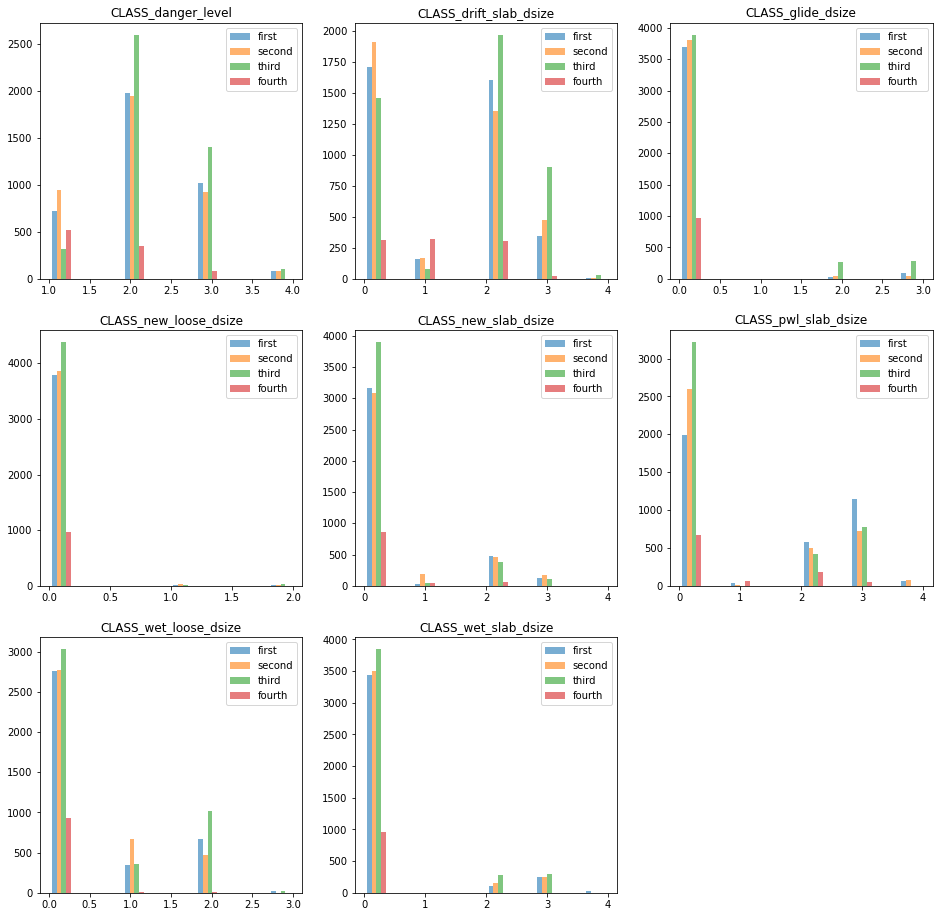

In [23]:
plot_season_danger_dsize(season_labels, compare_means, danger_dsize_list, 
                         3, 3, (16, 16), 0, 12)

### Level fill, min, and max

Next, we can examine the means of the `lev_min` and `lev_max` columns after removing the places where they are 0, or "not given". Thus, these means will mean something like "of the times when we have a level min and max, what were they?".

**Note!** There are five cases for the `lev_fill` columns. This corresponds to the different drawings for where the avalanche is likely to take place (little mountain picture on RegObs).
- `0`: level is not given
- `1`: *above*: min is 0, max is height given (everything above is avalanche zone)
- `2`: *below*: min is 0, max is height given (everything below is avalanche zone)
- `3`: *above and below*: never used
- `4`: *between*: min is min given, max is max given

So to be able to plot these columns, I first need to filter out the the rows where `CLASS_..._lev_fill` is 0. Then I can create ranges, or simply plot min and max columns again.

In [24]:
class_columns = [col for col in lev_fill_min_max if col.startswith('CLASS')]
class_columns

['CLASS_drift_slab_lev_fill',
 'CLASS_glide_lev_fill',
 'CLASS_new_loose_lev_fill',
 'CLASS_new_slab_lev_fill',
 'CLASS_pwl_slab_lev_fill',
 'CLASS_wet_loose_lev_fill',
 'CLASS_wet_slab_lev_fill']

In [25]:
real_columns = [col.replace('CLASS', 'REAL') for col in class_columns]
real_columns = [[col.replace('fill', 'min'), col.replace('fill', 'max')] for col in real_columns]
real_columns

[['REAL_drift_slab_lev_min', 'REAL_drift_slab_lev_max'],
 ['REAL_glide_lev_min', 'REAL_glide_lev_max'],
 ['REAL_new_loose_lev_min', 'REAL_new_loose_lev_max'],
 ['REAL_new_slab_lev_min', 'REAL_new_slab_lev_max'],
 ['REAL_pwl_slab_lev_min', 'REAL_pwl_slab_lev_max'],
 ['REAL_wet_loose_lev_min', 'REAL_wet_loose_lev_max'],
 ['REAL_wet_slab_lev_min', 'REAL_wet_slab_lev_max']]

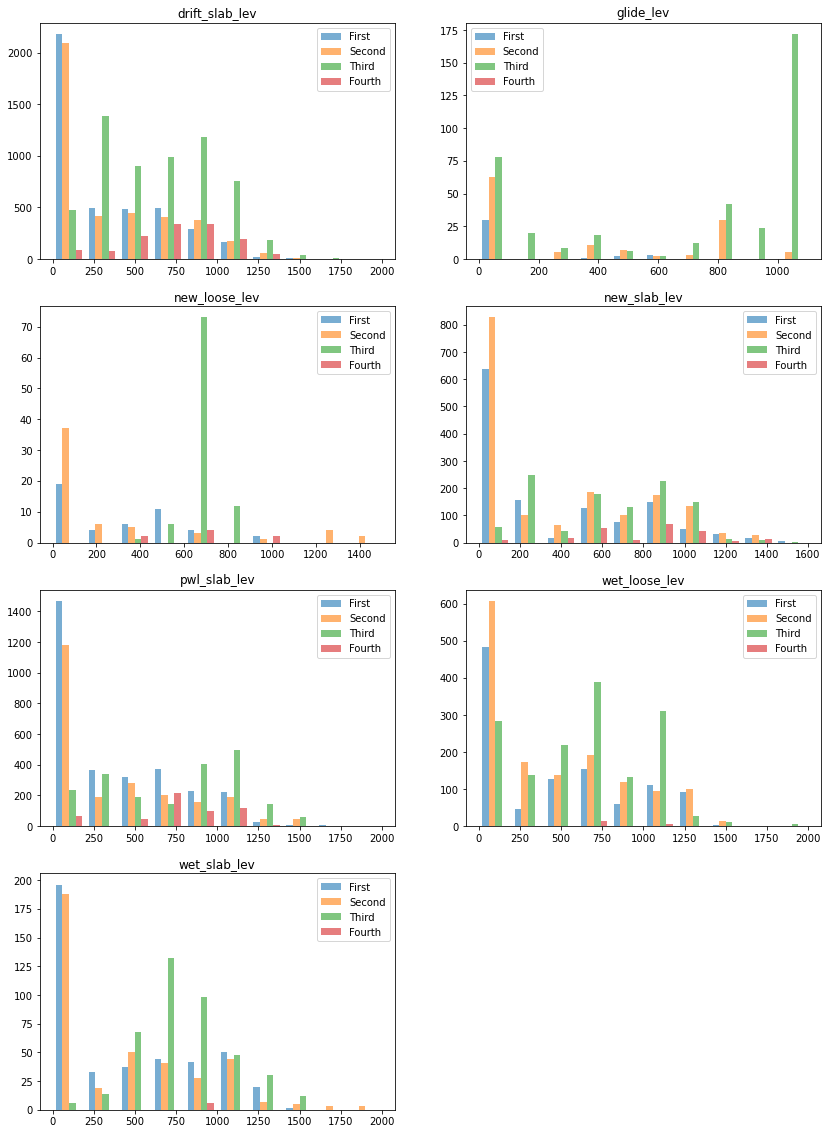

In [26]:
# everything above is avalanche zone
plot_season_levels(season_labels, real_columns, class_columns, 1)

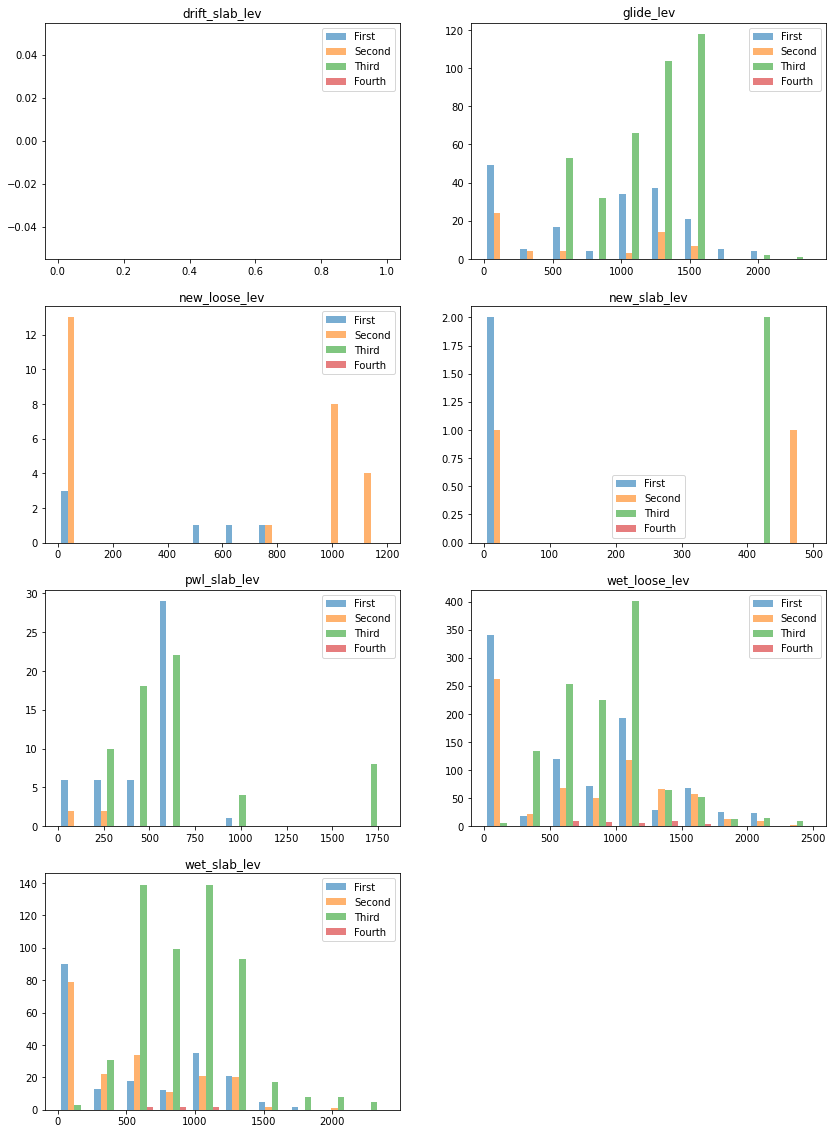

In [27]:
# everything below is avalanche zone
plot_season_levels(season_labels, real_columns, class_columns, 2)

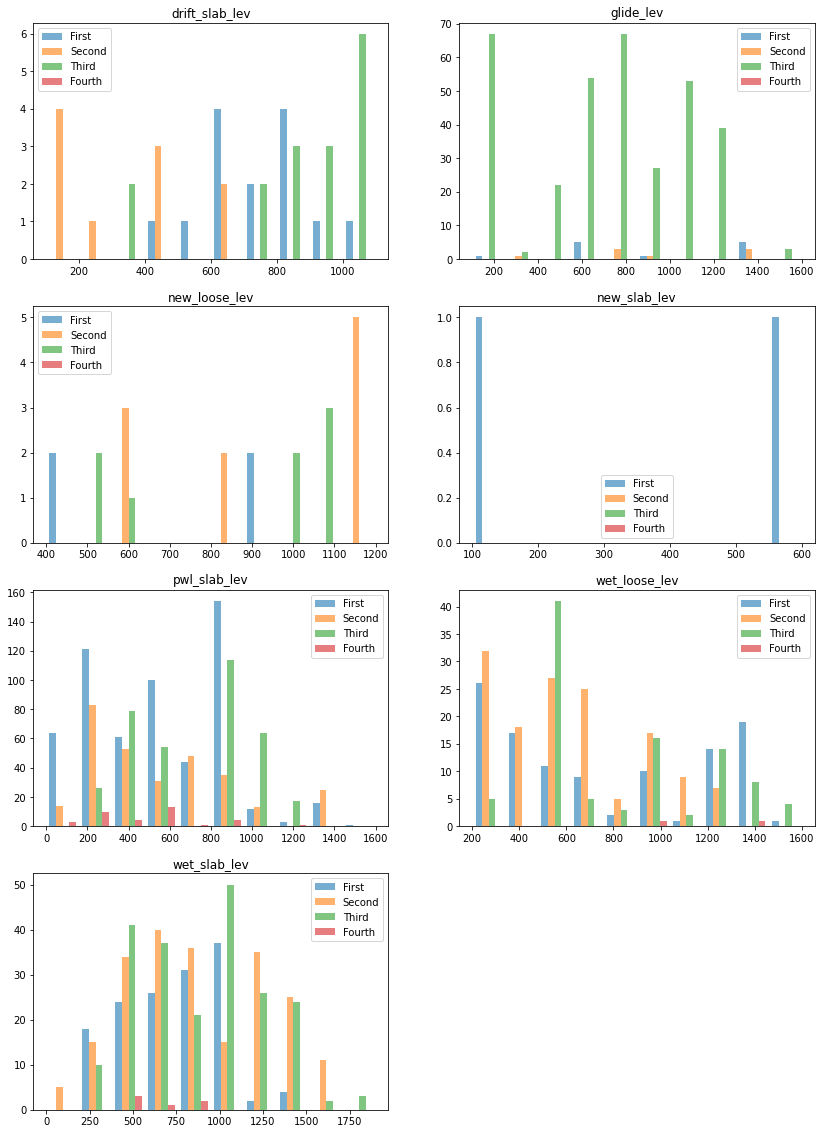

In [28]:
# everything in between is avalanche level
plot_season_levels(season_labels, real_columns, class_columns, 4)

### Avalanche problems

Now we can look at the avalanche problems. For the avalanche problem plots, I will need to filter out where the problems are 0, or 'not given'. This will allow us better to see when the problem does occur, what *sensitivity* it has (or how likely it is to trigger an avlanche if you step on it). This is similar to what I did for the `lev_fill`, `lev_min`, and `lev_max` columns.

In [29]:
problem_list = [problem for problem in first_labels.columns.values if 'prob' in problem]
problem_list

['CLASS_problem_1',
 'CLASS_problem_2',
 'CLASS_problem_3',
 'CLASS_problem_amount',
 'CLASS_drift_slab_prob',
 'CLASS_glide_prob',
 'CLASS_new_loose_prob',
 'CLASS_new_slab_prob',
 'CLASS_pwl_slab_prob',
 'CLASS_wet_loose_prob',
 'CLASS_wet_slab_prob']

/home/jakidxav/anaconda3/envs/avalanche_ml/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6623: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/home/jakidxav/anaconda3/envs/avalanche_ml/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6624: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


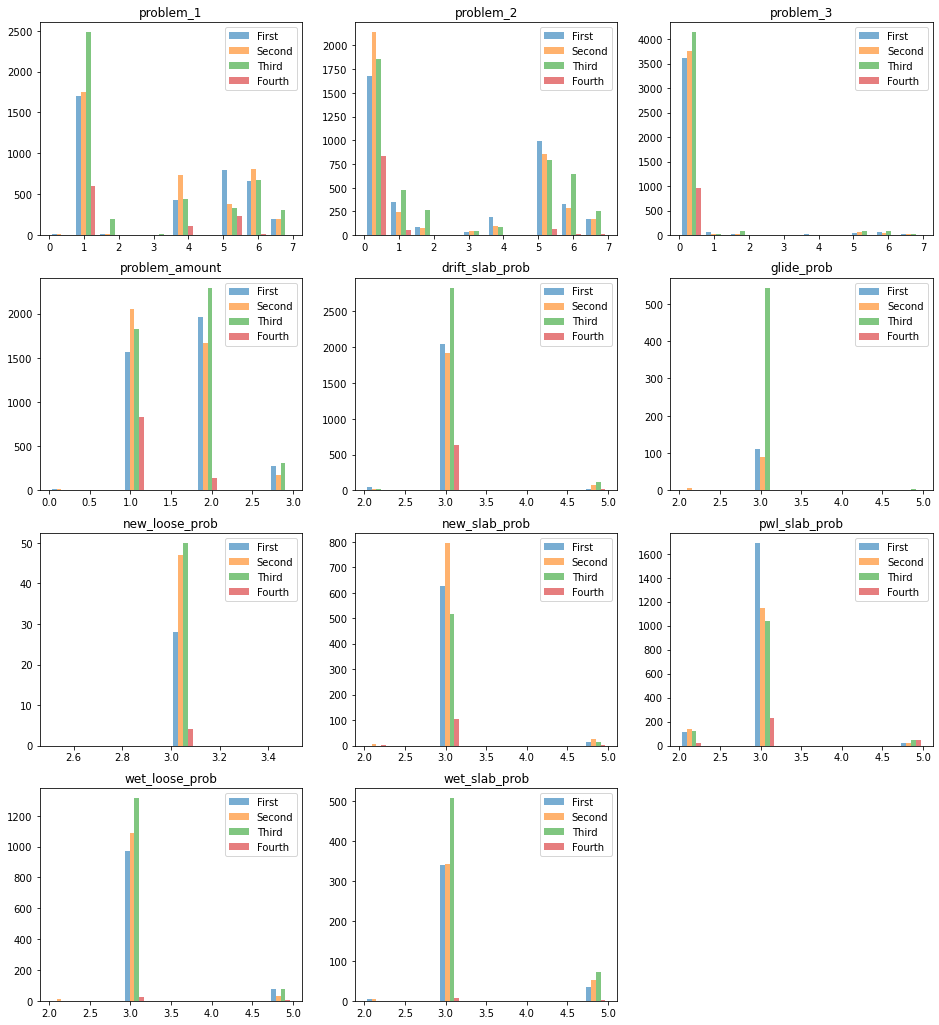

In [30]:
plot_season_problems(season_labels, problem_list)

## By region

Much like we did for different atmospheric and avalanche bulletin variables in each season, we can also look at distributions and averages for each region.

First, in order to group by regions, we need to reorder the indices of the MultiIndex object.

In [31]:
regions = labeled_data.data.reorder_levels([1, 0])
labels = labeled_data.label.reorder_levels([1, 0])

In [32]:
# what regions do we have data for
regions_list_sub = np.unique(regions.index.get_level_values(0))
regions_list_sub

array([3003, 3006, 3007, 3009, 3010, 3011, 3012, 3013, 3014, 3015, 3016,
       3017, 3022, 3023, 3024, 3027, 3028, 3029, 3031, 3032, 3034, 3035,
       3037])

In [33]:
# check the labels to make sure we have the same regions
np.unique(labels.index.get_level_values(0))

array([3003, 3006, 3007, 3009, 3010, 3011, 3012, 3013, 3014, 3015, 3016,
       3017, 3022, 3023, 3024, 3027, 3028, 3029, 3031, 3032, 3034, 3035,
       3037])

So we will need to subset these regions when we plot them. Below I will show how we can subset for Norway, then for all regions, and then for the regions we are predicting for.

In [34]:
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
print("Geometry Column Name : ", countries.geometry.name)
print("Dataset Size : ", countries.shape)
countries.head()

Geometry Column Name :  geometry
Dataset Size :  (177, 6)


,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [35]:
'Norway' in countries.name.values

True

In [36]:
norway = countries[countries.name == 'Norway']
norway

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
21,5320045,Europe,Norway,-99,364700.0,"MULTIPOLYGON (((15.14282 79.67431, 15.52255 80..."


In [37]:
# data from: http://api.nve.no/doc/snoeskredvarsel
# note: these names had to be changed manually to match those found in regions geodataframe
file = './data/regions_id_dict.txt'
with open(file, 'r') as f:
    regions_id_dict = json.load(f)

# we can create a dataframe from our dictionary of saved region ids
regions_id_df = pd.DataFrame.from_dict(regions_id_dict, orient='index').reset_index()
regions_id_df.columns = ['region_id', 'safeName']
regions_id_df['region_id'] = regions_id_df['region_id'].astype(np.int)
regions_id_df.head()

,region_id,safeName
0,3003,Nordenskioldland
1,3006,Finnmarkskysten
2,3007,Vest_Finnmark
3,3009,Nord_Troms
4,3010,Lyngen


In [38]:
# these are our region shapefiles
map_regions = gpd.read_file('./data/regions.json')
map_regions.head()

,safeName,geometry
0,Heiane,"POLYGON ((7.11045 59.76332, 7.09629 59.78278, ..."
1,Hardanger,"POLYGON ((7.48804 60.09884, 7.58306 60.17572, ..."
2,Hallingdal,"POLYGON ((8.36633 61.04826, 8.30920 61.09172, ..."
3,Voss,"POLYGON ((6.02558 61.13354, 5.80863 61.14487, ..."
4,Indre_Sogn,"POLYGON ((7.51475 61.76033, 7.41250 61.85751, ..."


In [39]:
# next we can merge these two dataframes by their region name
map_regions = map_regions.merge(regions_id_df, on='safeName')
map_regions = map_regions.set_index('region_id').sort_index()

In [40]:
regions_to_predict = map_regions.loc[regions_list_sub]
regions_to_predict

,safeName,geometry
region_id,,
3003,Nordenskioldland,"POLYGON ((16.13849 78.36358, 16.01725 78.35302..."
3006,Finnmarkskysten,"POLYGON ((28.57569 71.07968, 27.66960 71.19911..."
3007,Vest_Finnmark,"POLYGON ((23.57282 71.01723, 23.24746 71.18623..."
3009,Nord_Troms,"POLYGON ((21.00663 70.23751, 20.66945 70.24896..."
3010,Lyngen,"POLYGON ((20.49882 69.94028, 20.22103 70.05576..."
3011,Tromso,"POLYGON ((20.42187 70.24184, 20.13619 70.35381..."
3012,Sor_Troms,"POLYGON ((18.00493 69.53661, 17.66422 69.71550..."
3013,Indre_Troms,"POLYGON ((18.95397 69.44915, 18.95344 69.52040..."
3014,Lofoten_Vesteralen,"POLYGON ((16.26780 69.34534, 16.15952 69.35995..."


Let's make sure we have the right number of regions: there should be 23.

In [41]:
assert(regions_to_predict.shape[0] == 23)

### Notes:

These points are now not in the right order, although I do not think that we need them. We could shuffle them.

We could also drop the Nordenskiold Land data for now for 22 regions?

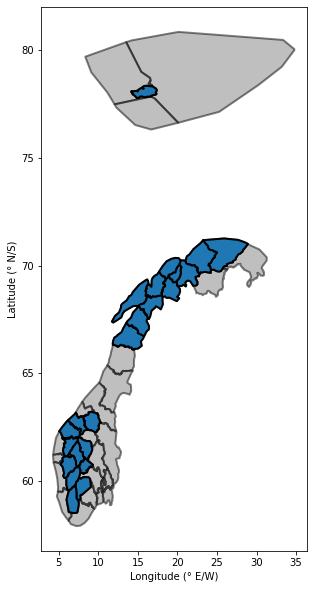

In [42]:
fig, ax = plt.subplots(figsize=(10, 10))

map_regions.plot(facecolor='grey', edgecolor='k', alpha=0.5, linewidth=2.0, ax=ax)
regions_to_predict.plot(facecolor='tab:blue', edgecolor='k', linewidth=2.0, ax=ax)

ax.set_xlabel('Longitude (° E/W)')
ax.set_ylabel('Latitude (° N/S)')

plt.show()

### Plotting seasonal and overall distributions
### Weather data

In [43]:
def region_averages(list_of_regions, col_list):
    """
    Calculate average values for every column in col_list
    
    Arguments:
        list_of_regions(list): the regions you want to consider for plotting
        col_list(list): the columns you want to average over
        
        Note! You should be careful when doing averages for the lev_fill and _prop columns,
        as illustrated above.
        
    Returns:
        df(DataFrame): a Pandas DataFrame containing the means for each region in
        list_of_regions and every column in col_list
    """
    first_index = list_of_regions[0]
    df = pd.DataFrame(regions.loc[first_index][col_list].mean()).T
    df.index = [first_index]

    for i in range(1, len(list_of_regions)):
        index = list_of_regions[i]
        temp = pd.DataFrame(regions.loc[index][col_list].mean()).T
        temp.index= [index]

        df = pd.concat([df, temp])

    return df

In [44]:
plot_list = ['temp_min_0', 'temp_max_0', 'precip_0', 'wind_speed_0', 'temp_lev_0', 'temp_freeze_lev_0']
wx_means = region_averages(regions_list_sub, plot_list)
wx_means

,temp_min_0,temp_max_0,precip_0,wind_speed_0,temp_lev_0,temp_freeze_lev_0
3003,-15.408020,-10.130092,1.688777,8.472789,700.000000,98.634398
3006,-8.063889,-2.696306,37.158933,9.525000,700.000000,384.017361
3007,-9.070383,-3.410567,13.320915,9.919167,1053.500000,372.178875
3009,-9.495990,-3.704392,13.087512,9.604167,1053.500000,527.980558
3010,-8.326808,-3.113750,13.551203,9.238333,1053.500000,492.111908
3011,-5.521630,-0.536983,13.693067,8.842500,700.000000,463.944283
3012,-6.979225,-1.712083,14.060885,8.073333,700.000000,454.984200
3013,-9.781317,-3.913017,13.195248,9.080000,1053.500000,537.602925
3014,-4.420092,1.075158,14.750400,8.349167,700.000000,463.781417
3015,-8.635627,-3.448855,14.475110,9.210702,1053.511706,550.007349


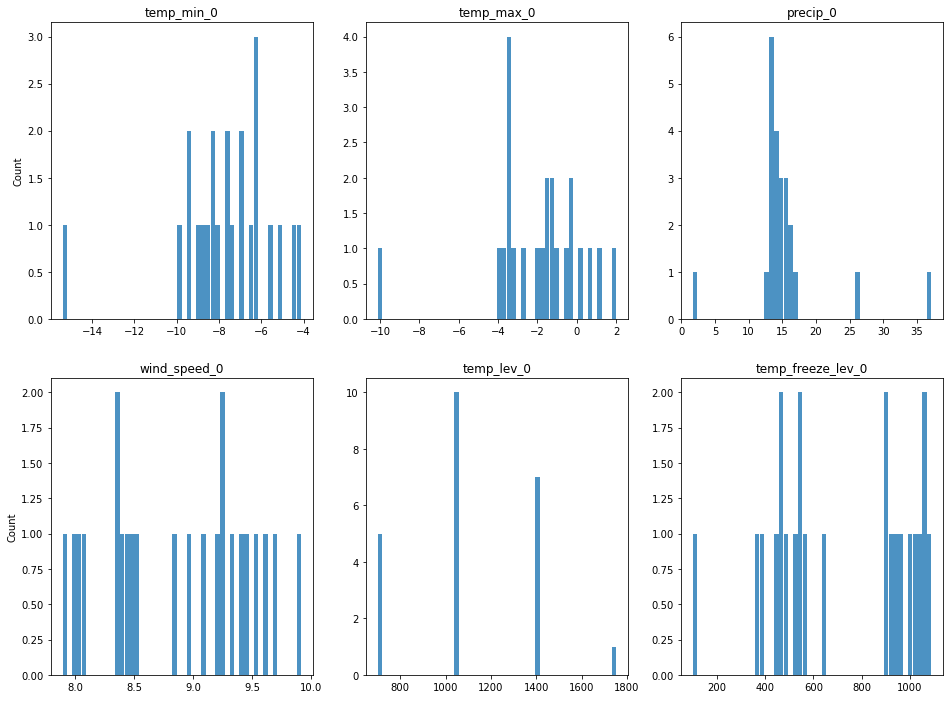

In [45]:
plot_region_weather(wx_means, plot_list)

To be able to plot the means on our figure of Norway, we need to concatenate our GeoPandas and Pandas DataFrames. We can do that below.

In [46]:
geo_wx = gpd.GeoDataFrame(pd.concat([regions_to_predict, wx_means], ignore_index=False, axis=1))
geo_wx.head()

,safeName,geometry,temp_min_0,temp_max_0,precip_0,wind_speed_0,temp_lev_0,temp_freeze_lev_0
3003,Nordenskioldland,"POLYGON ((16.13849 78.36358, 16.01725 78.35302...",-15.408020,-10.130092,1.688777,8.472789,700.0,98.634398
3006,Finnmarkskysten,"POLYGON ((28.57569 71.07968, 27.66960 71.19911...",-8.063889,-2.696306,37.158933,9.525000,700.0,384.017361
3007,Vest_Finnmark,"POLYGON ((23.57282 71.01723, 23.24746 71.18623...",-9.070383,-3.410567,13.320915,9.919167,1053.5,372.178875
3009,Nord_Troms,"POLYGON ((21.00663 70.23751, 20.66945 70.24896...",-9.495990,-3.704392,13.087512,9.604167,1053.5,527.980558
3010,Lyngen,"POLYGON ((20.49882 69.94028, 20.22103 70.05576...",-8.326808,-3.113750,13.551203,9.238333,1053.5,492.111908


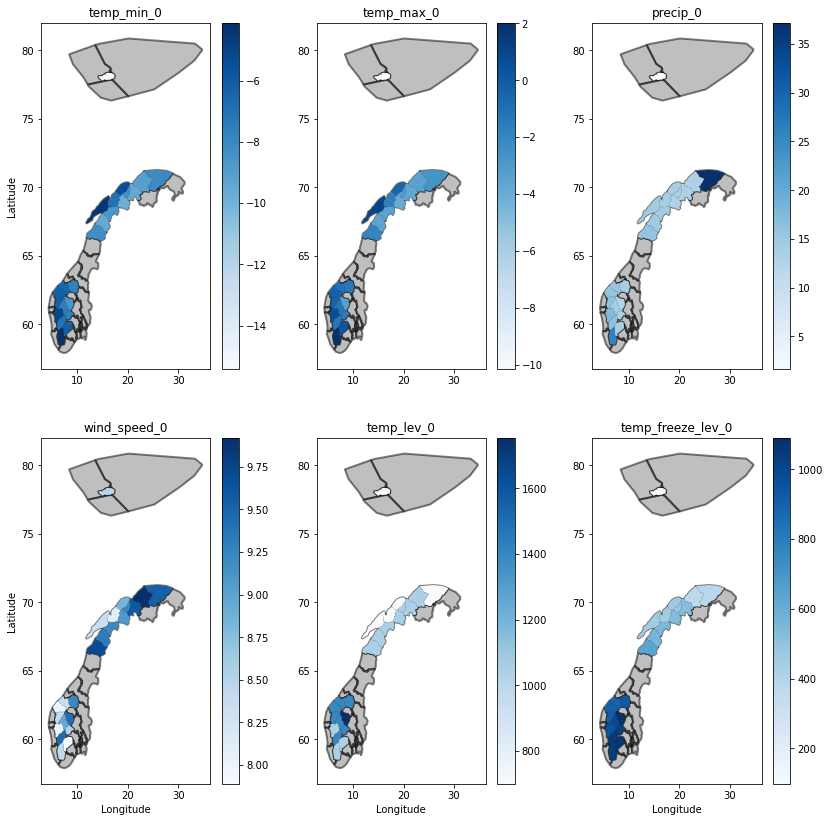

In [47]:
plot_spatial_means(geo_wx, plot_list, map_regions)

### Danger level and dsize

In [48]:
danger_means = region_averages(regions_list_sub, ['danger_level_1'])
geo_danger = gpd.GeoDataFrame(pd.concat([regions_to_predict, danger_means], ignore_index=False, axis=1))
geo_danger

,safeName,geometry,danger_level_1
3003,Nordenskioldland,"POLYGON ((16.13849 78.36358, 16.01725 78.35302...",2.134354
3006,Finnmarkskysten,"POLYGON ((28.57569 71.07968, 27.66960 71.19911...",1.938889
3007,Vest_Finnmark,"POLYGON ((23.57282 71.01723, 23.24746 71.18623...",2.165000
3009,Nord_Troms,"POLYGON ((21.00663 70.23751, 20.66945 70.24896...",2.103333
3010,Lyngen,"POLYGON ((20.49882 69.94028, 20.22103 70.05576...",2.175000
3011,Tromso,"POLYGON ((20.42187 70.24184, 20.13619 70.35381...",2.140000
3012,Sor_Troms,"POLYGON ((18.00493 69.53661, 17.66422 69.71550...",2.106667
3013,Indre_Troms,"POLYGON ((18.95397 69.44915, 18.95344 69.52040...",2.121667
3014,Lofoten_Vesteralen,"POLYGON ((16.26780 69.34534, 16.15952 69.35995...",1.976667
3015,Ofoten,"POLYGON ((18.12592 68.53651, 18.02329 68.60846...",2.157191


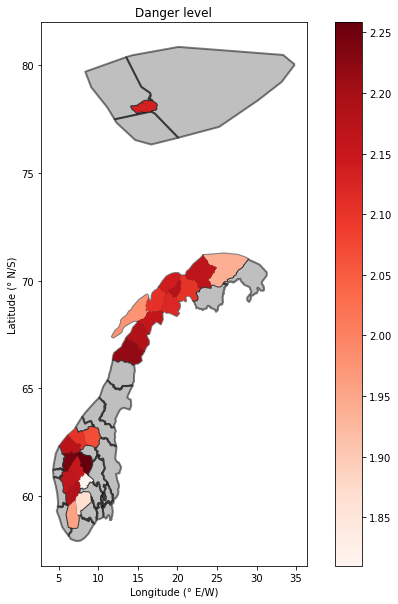

In [49]:
fig, ax = plt.subplots(figsize=(10, 10))

map_regions.plot(facecolor='grey', edgecolor='k', alpha=0.5, linewidth=2.0, ax=ax)
geo_danger.plot(column='danger_level_1', legend=True, cmap='Reds', ax=ax)

ax.set_xlabel('Longitude (° E/W)')
ax.set_ylabel('Latitude (° N/S)')
ax.set_title('Danger level')

plt.show()

### Level fill, min, and max


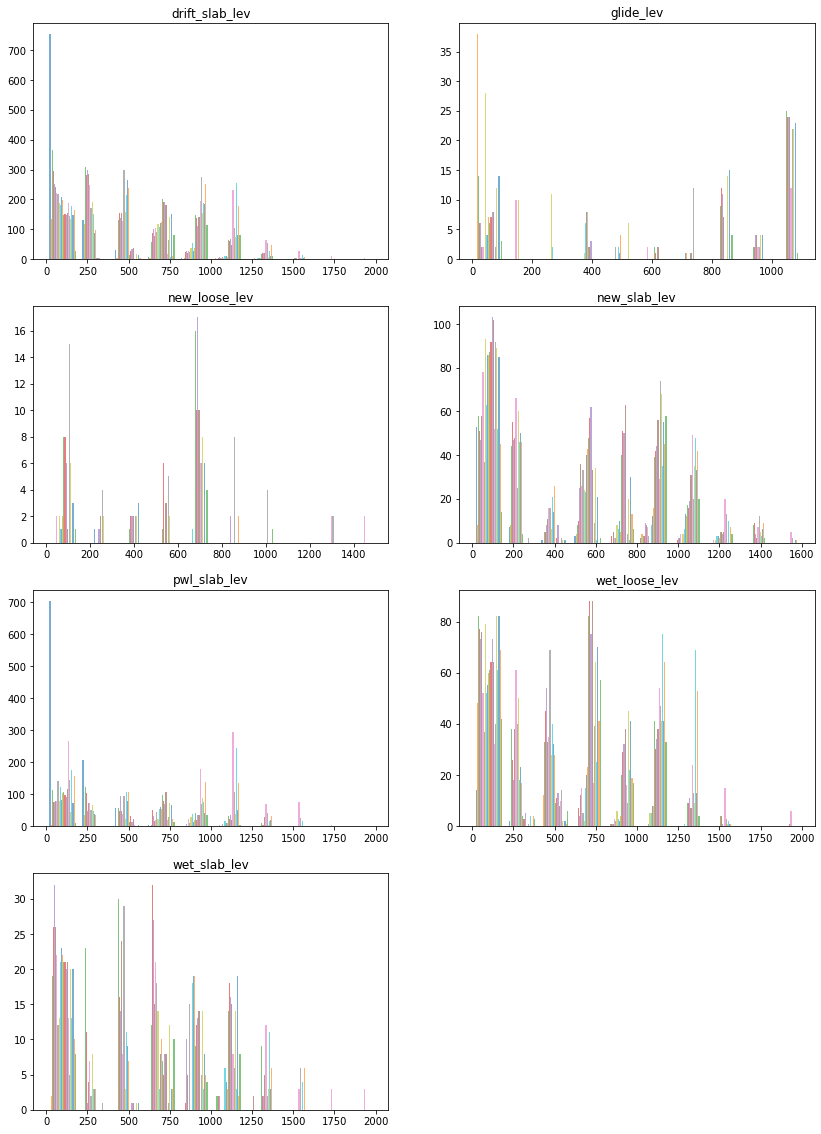

In [50]:
plot_region_levels(labels, regions_list_sub, real_columns, class_columns, 1)

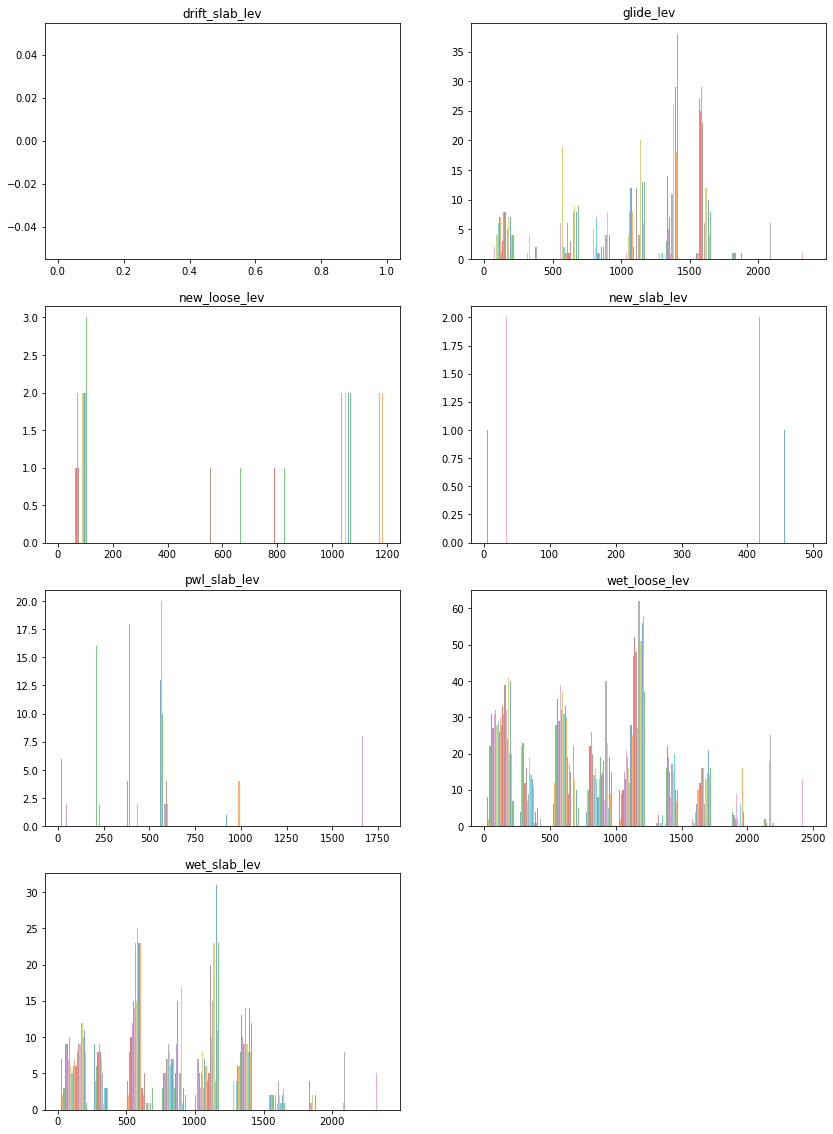

In [51]:
plot_region_levels(labels, regions_list_sub, real_columns, class_columns, 2)

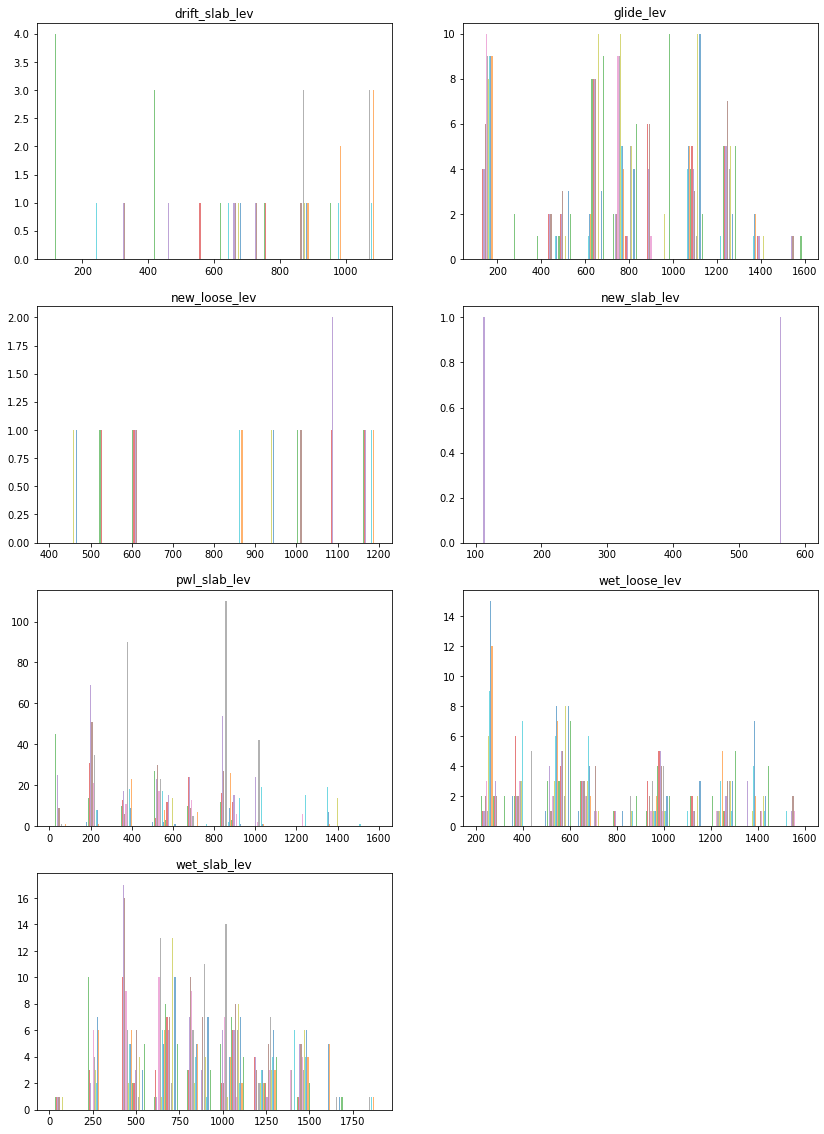

In [52]:
plot_region_levels(labels, regions_list_sub, real_columns, class_columns, 4)

### Avalanche problems

In [53]:
problem_list = [problem for problem in labeled_data.label.columns.values if 'prob' in problem]
problem_list

['CLASS_problem_1',
 'CLASS_problem_2',
 'CLASS_problem_3',
 'CLASS_problem_amount',
 'CLASS_drift_slab_prob',
 'CLASS_glide_prob',
 'CLASS_new_loose_prob',
 'CLASS_new_slab_prob',
 'CLASS_pwl_slab_prob',
 'CLASS_wet_loose_prob',
 'CLASS_wet_slab_prob']

/home/jakidxav/anaconda3/envs/avalanche_ml/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6623: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/home/jakidxav/anaconda3/envs/avalanche_ml/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6624: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


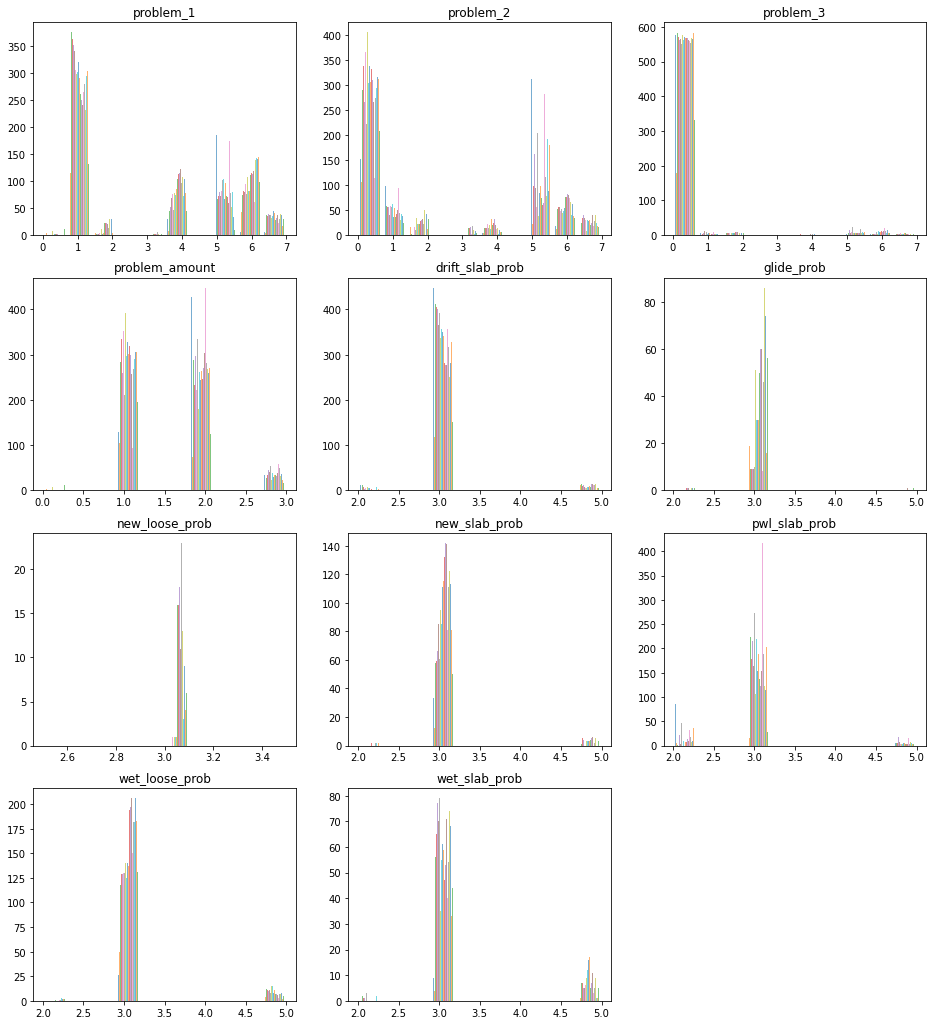

In [54]:
plot_region_problems(labels, regions_list_sub, problem_list)

# Comments

**Summary**:
Many of the plots made for splitting the data into regions looks very similar to those we made when we split the data by seasons (for example, the avalanche problem plots). There is still a decent amount of variability between regions when it comes to atmospheric conditions and different avalanche descriptors. This is to be expected. 

However, the main advantage that I see in splitting the data by regions is that you can capture more of the interseasonal variability at any given time. I see predicting for data given the limited size of our dataset to be the main barrier to overcome for this project.

**Recommendations**:
I would split the data into training, validation, and testing sets in a way that creates data that is distributed as equally as possible across all variables. In order to do this, I think that we need to find a way to minimize the spatial correlation between neighboring regions. For instance, one region in the north and one in the south of Norway might be good to have in each data split because they are unlikely to have *very* weather conditions and frequencies of avalanche problems. However, two neighboring regions are likely to have similar danger levels, similar avalanche descriptors, similar weather patterns, etc., meaning that too many neighboring regions would not create a representative training set. We can look into this more below.

# Correlations between DataFrames

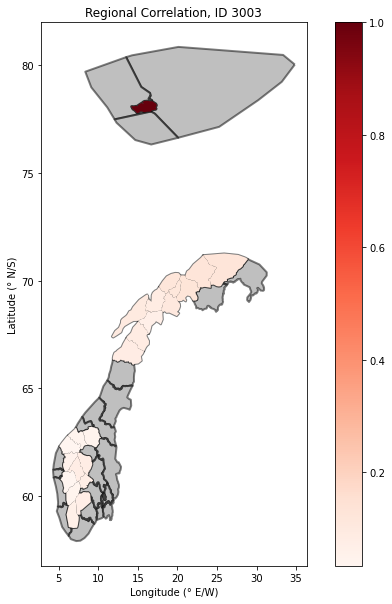

In [55]:
regions_df = [regions.loc[idx] for idx in regions_list_sub]
plot_spatial_correlation(3003, regions_df, regions_list_sub, regions_to_predict, map_regions)

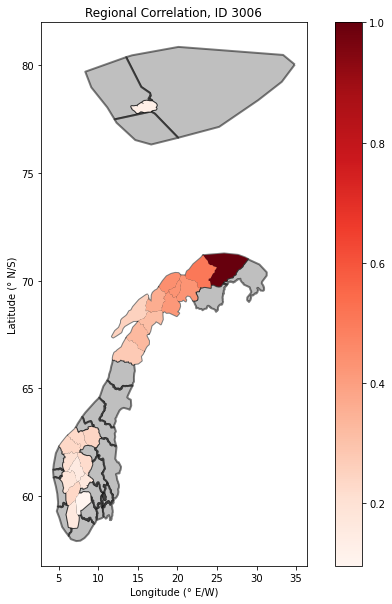

In [56]:
plot_spatial_correlation(3006, regions_df, regions_list_sub, regions_to_predict, map_regions)

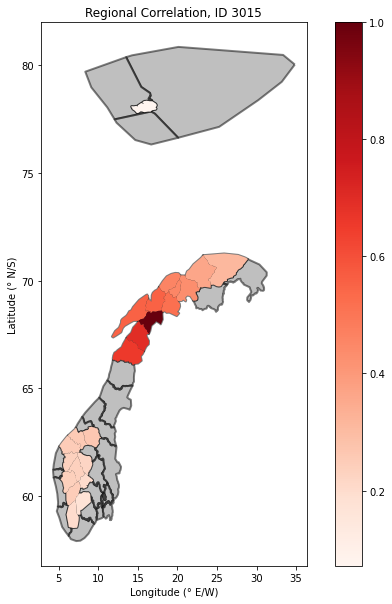

In [57]:
plot_spatial_correlation(3015, regions_df, regions_list_sub, regions_to_predict, map_regions)

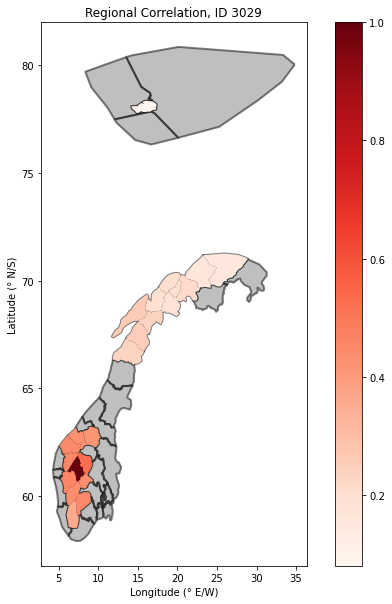

In [58]:
plot_spatial_correlation(3029, regions_df, regions_list_sub, regions_to_predict, map_regions)

# Splitting data, plotting distributions

This looks good. The one A region in Svalbard is not very correlated with other regions. We don't have much data for region 3003, and the data that we do have is on the extreme side of the danger level scale. We can get rid of this region when splitting up regions for the training, validation, and test sets. An interested thing we *could* do is use it as some sort of further hold-out set after the test set as a way to judge how our model performs in areas where we don't have much data.

For the rest of the 22 remaining regions, we can split them into 3 groups based on the plots above: Troms, Nordland, and South. This means that the validation and test sets will have 3 regions in them, one from each of Troms, Nordland, and South. The remaining 16 regions will go to the training set. One thing we need to make sure of when splitting the data is to ensure the training, validation, and test sets have similar distributions of input and output variables (or at the very least the validation and test sets). It is very important that we train our model and make predictions with that model on the same distribution of data.

**Note**: the following distribution plots are produced with the keyword `density=True`. I did this so that the training set could be plotted alongside the smaller validation and testing sets.

In [59]:
rounds = 3
seed = 'Cascades'
rand = random.Random(seed)

result = []
for _ in range(0, rounds):
    troms = rand.sample([3006, 3007, 3009, 3010, 3011, 3012, 3013], k=7)
    nordland = rand.sample([3014, 3015, 3016, 3017], k=4)
    south = rand.sample([3022, 3023, 3024, 3027, 3028, 3029, 3031, 3032, 3034, 3035, 3037], k=11)

    train_regions = troms[2:] + nordland[2:] + south[2:]
    eval_regions = [troms[0], nordland[0], south[0]]
    test_regions = [troms[1], nordland[1], south[1]]
    result.append([train_regions, eval_regions, test_regions])
    
for i, split in enumerate(result):
    #print(split[0])
    print('Train regions: {}'.format(split[0]))
    print('Val regions: {}'.format(split[1]))
    print('Test regions: {}\n'.format(split[2]))

Train regions: [3011, 3007, 3006, 3009, 3010, 3017, 3014, 3032, 3034, 3029, 3028, 3031, 3037, 3027, 3023, 3022]
Val regions: [3012, 3015, 3024]
Test regions: [3013, 3016, 3035]

Train regions: [3007, 3012, 3010, 3009, 3013, 3017, 3014, 3032, 3027, 3029, 3022, 3031, 3023, 3037, 3024, 3028]
Val regions: [3011, 3016, 3035]
Test regions: [3006, 3015, 3034]

Train regions: [3009, 3013, 3006, 3011, 3012, 3017, 3014, 3037, 3031, 3028, 3034, 3029, 3024, 3027, 3022, 3035]
Val regions: [3007, 3015, 3023]
Test regions: [3010, 3016, 3032]



Okay, let's see how the distribution of input and output variables look when we split the data with one of the data splits listed above.

In [60]:
# 0, 1, or 2
idx = 1
train_idx, val_idx, test_idx = result[idx][0], result[idx][1], result[idx][2]

print('Training set contains    {} regions.'.format(len(train_idx)))
print('Validation set contains  {}  regions.'.format(len(val_idx)))
print('Testing set contains     {}  regions.'.format(len(test_idx)))

# create training, validation, and test sets and labels
X_train = pd.concat([regions.loc[idx] for idx in train_idx])
y_train = pd.concat([labels.loc[idx] for idx in train_idx])

X_val = pd.concat([regions.loc[idx] for idx in val_idx])
y_val = pd.concat([labels.loc[idx] for idx in val_idx])

X_test = pd.concat([regions.loc[idx] for idx in test_idx])
y_test = pd.concat([labels.loc[idx] for idx in test_idx])

Training set contains    16 regions.
Validation set contains  3  regions.
Testing set contains     3  regions.


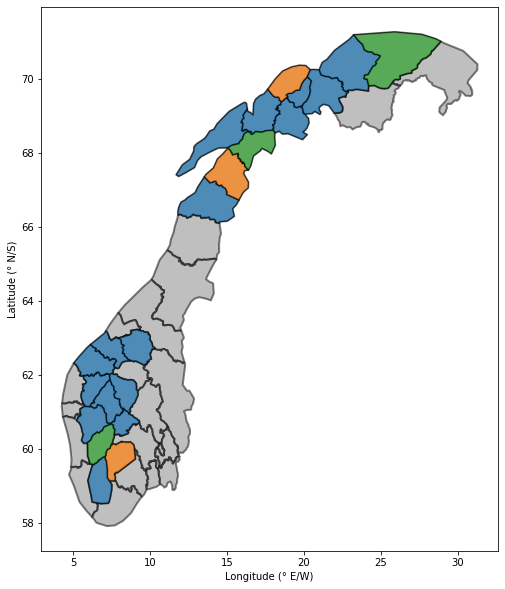

In [61]:
fig, ax = plt.subplots(figsize=(10, 10))

# subset map_regions to exclude svalbard
to_clip = []
for idx in map_regions.index:
    if map_regions.loc[idx].safeName.startswith('Svalbard') or map_regions.loc[idx].safeName == 'Nordenskioldland':
        to_clip.append(idx)
regions_clipped = map_regions.drop(to_clip)

# subset for train, val, and test sets
plot_train = regions_to_predict.loc[train_idx]
plot_val = regions_to_predict.loc[val_idx]
plot_test = regions_to_predict.loc[test_idx]

# plot country and region boundaries
regions_clipped.plot(facecolor='grey', edgecolor='k', alpha=0.5, linewidth=2.0, ax=ax)
plot_train.plot(color='tab:blue', edgecolor='k', alpha=0.7, label='Train', ax=ax)
plot_val.plot(color='tab:orange', edgecolor='k', alpha=0.7, label='Val', ax=ax)
plot_test.plot(color='tab:green', edgecolor='k', alpha=0.7, label='Test', ax=ax)

ax.set_xlabel('Longitude (° E/W)')
ax.set_ylabel('Latitude (° N/S)')

plt.show()

### Weather data

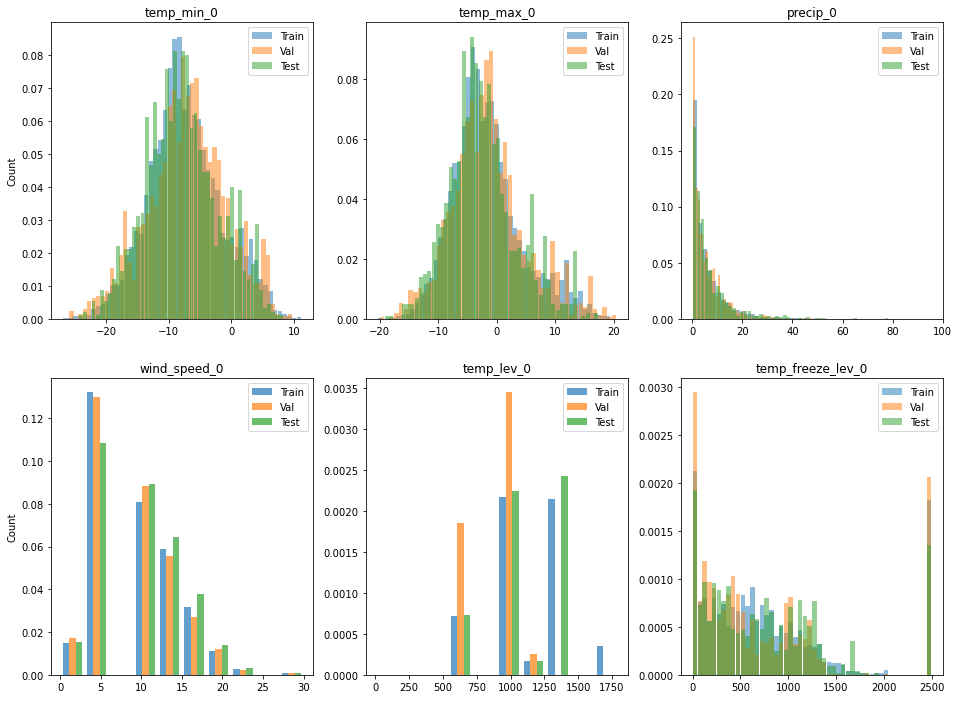

In [62]:
plot_split_weather(X_train, X_val, X_test)

This is excellent. The third data split that we created is showing a relatively equal distribution of values for input weather data. The only exception is `temp_lev_0`, which seems to be hard to balance.

What about other input and output variables?

## Output data
### Danger level and dsize

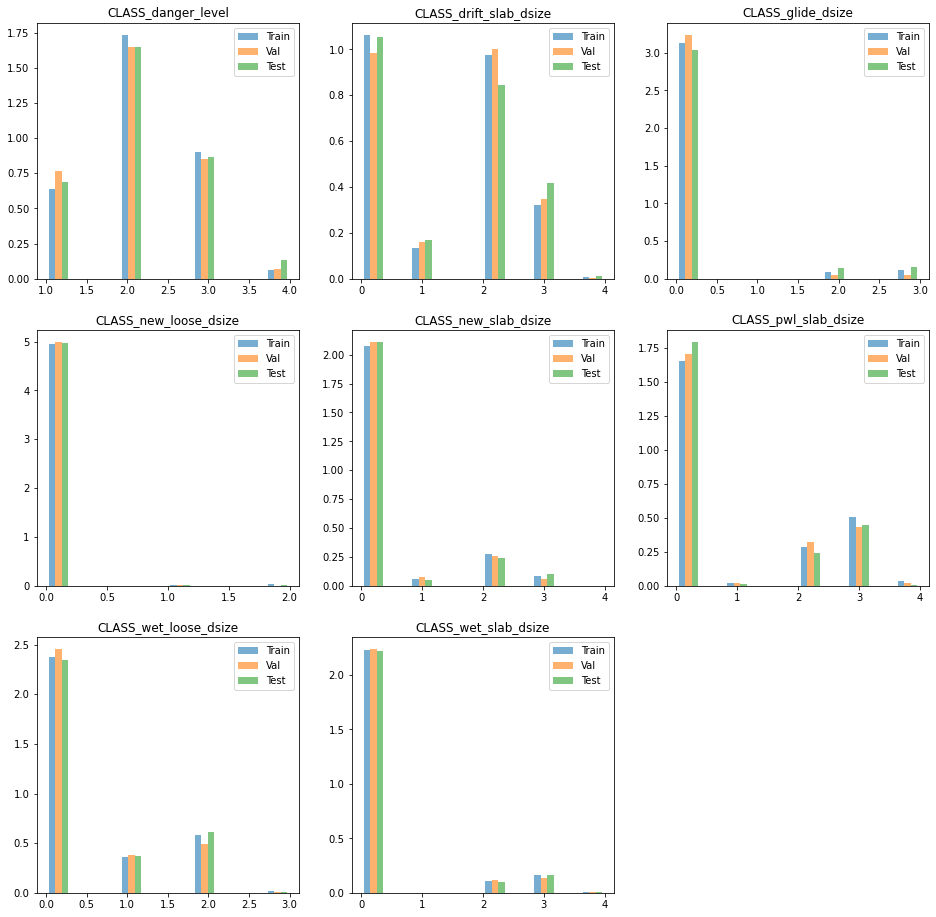

In [63]:
split_labels = [y_train, y_val, y_test]
plot_split_danger_dsize(split_labels, danger_dsize_list, 3, 3, (16, 16), 0, 12)

### Level fill, min, and max

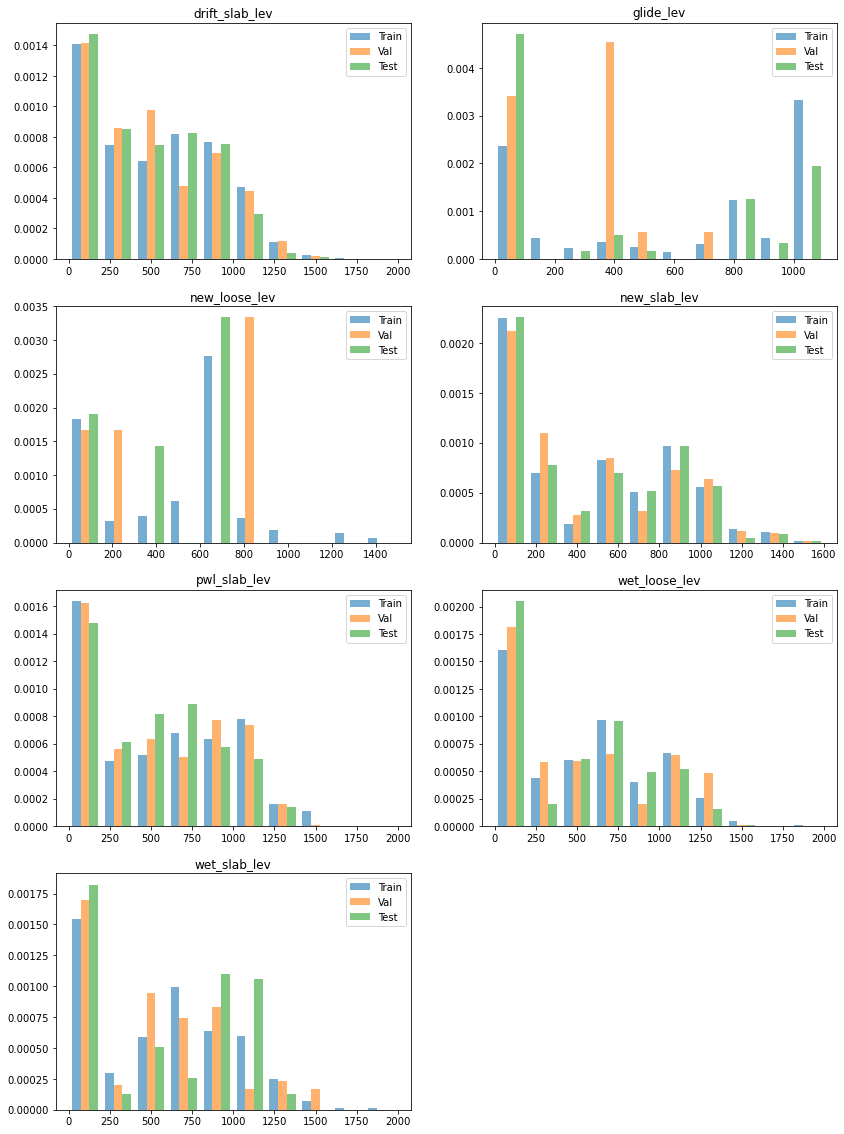

In [64]:
plot_split_levels(split_labels, real_columns, class_columns, 1)

/home/jakidxav/anaconda3/envs/avalanche_ml/lib/python3.7/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/home/jakidxav/anaconda3/envs/avalanche_ml/lib/python3.7/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


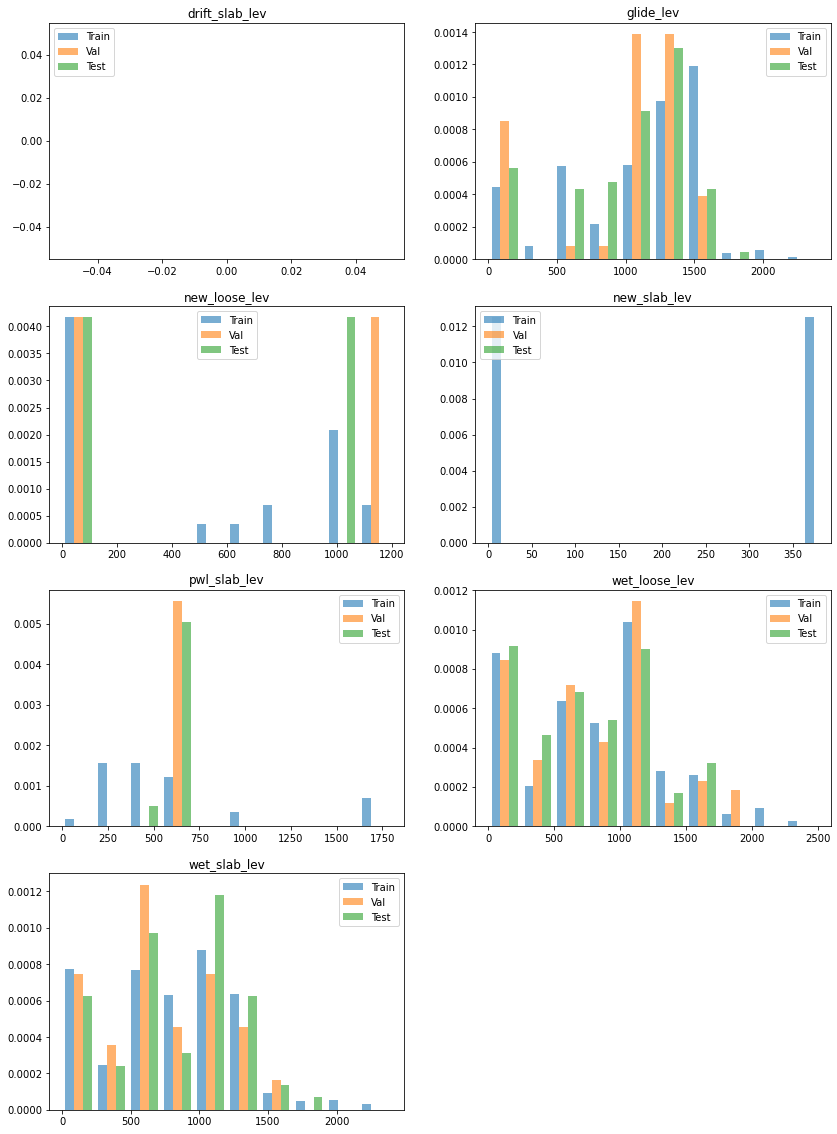

In [65]:
plot_split_levels(split_labels, real_columns, class_columns, 2)

/home/jakidxav/anaconda3/envs/avalanche_ml/lib/python3.7/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


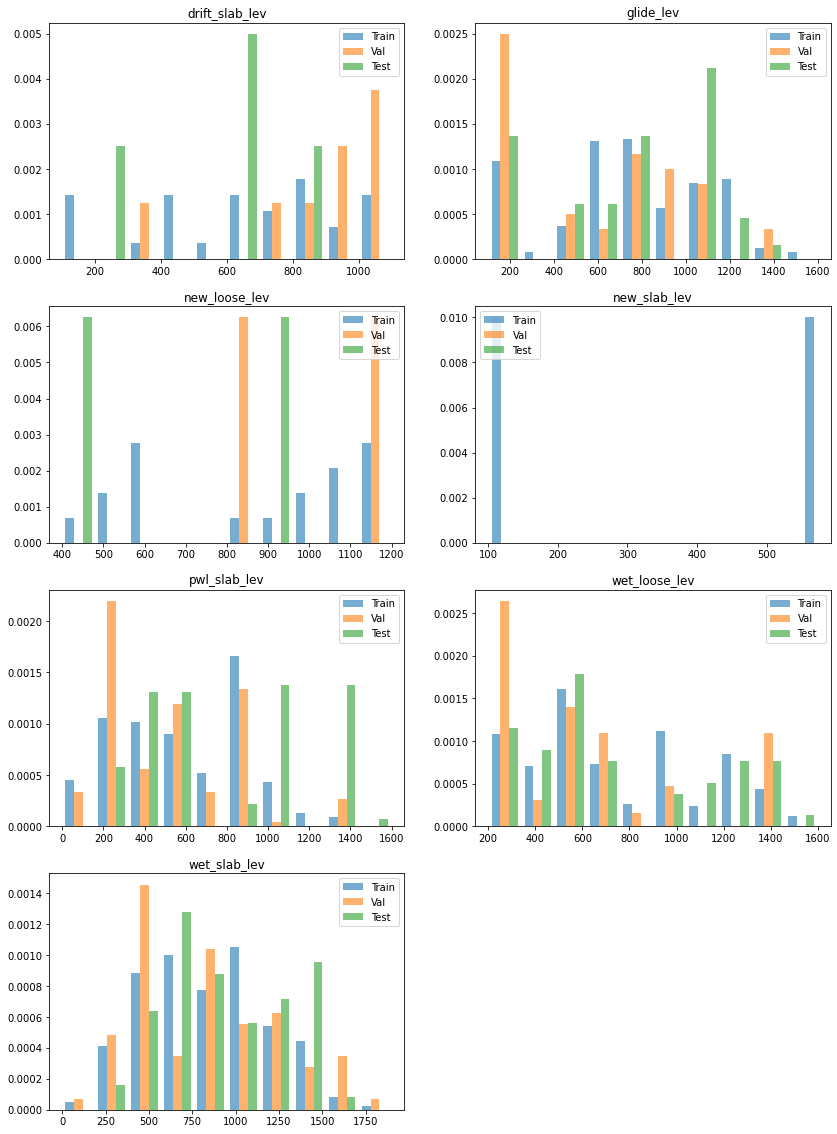

In [66]:
plot_split_levels(split_labels, real_columns, class_columns, 4)

### Avalanche problems

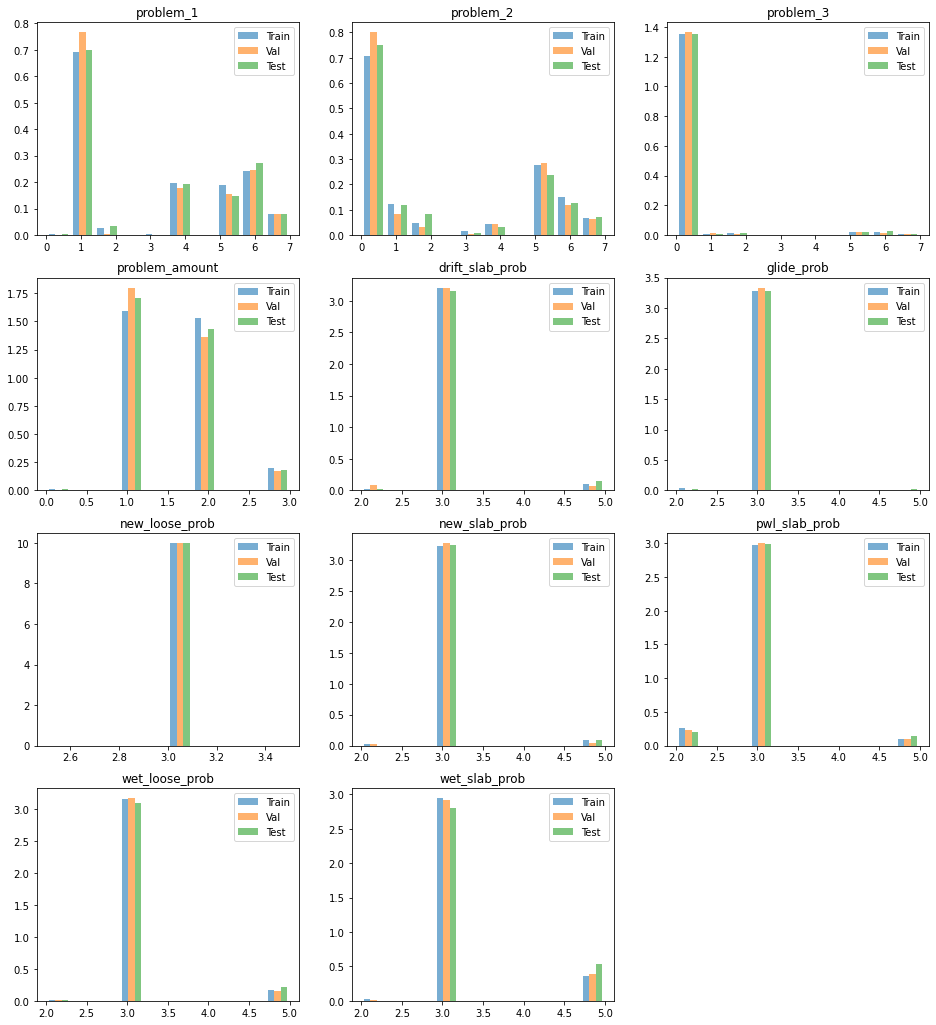

In [67]:
plot_split_problems(split_labels, problem_list)

So the avalanche problems are evenly distributed, while for the level min and max columns in our labels this is only true some of the time. **We could try and fix this by adding more data to the validation and test sets, but at the cost of removing data from the training data**. Because of the small size of our overall dataset, I do not recommend this.

Since we seem to have a good split in the input and output data, these are the regions I recommend using for the training, validation, and test sets:

In [68]:
print('Train regions: {}'.format(train_idx))
print('Val regions:   {}'.format(val_idx))
print('Test regions:  {}'.format(test_idx))

Train regions: [3007, 3012, 3010, 3009, 3013, 3017, 3014, 3032, 3027, 3029, 3022, 3031, 3023, 3037, 3024, 3028]
Val regions:   [3011, 3016, 3035]
Test regions:  [3006, 3015, 3034]
